In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
sns.set_context("talk",font_scale=1.5)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [147]:
def new_simlib(inpath, template_simlib_fname, output_fname, days_span=200, sampling_rate=2.0, sampling='coarse', whitespace=True):
    i=0
    docrows = []
    with open(inpath + "/" + template_simlib_fname, 'r') as template:
        for line in template:
            docrows.append(line)
            if 'MJD' in line:
                skiprows= i+1
                break
            i+=1

    hdr        = ["MJD", "IDEXPT", "FLT", "CCD GAIN", "CCD NOISE", "SKYSIG", "PSF1", "PSF2", "PSF 2/1 RATIO", "ZPTAVG", "ZPTERR", "MAG"]
    simlib_old = pd.read_csv(inpath + "/" + template_simlib_fname, names=hdr, skiprows=skiprows, delim_whitespace=whitespace, skipfooter=2)

    numsteps   = int(days_span/sampling_rate)
    
    if sampling == 'variable':
        #increase the sampling for TDEs and Kilonovae
        half = days_span/2
        forward = np.logspace(-1, 0.3, 162)
        backward = np.logspace(-1, 0.3, 80)
        backward = np.flip(backward)
        backward_pad = [2]*int((half-np.nansum(backward))/2)
        backward_pad = np.array(backward_pad)
        full_spacing = np.concatenate([backward_pad, backward, forward])
        mjdsteps = np.zeros(len(full_spacing))
        mjdsteps[0] = min(simlib_old['MJD'])
        
        for i in np.arange(1,len(full_spacing)):
            mjdsteps[i] = mjdsteps[i - 1] + full_spacing[i-1]
            
    else: 
        mjdsteps   = min(simlib_old['MJD']) + np.linspace(0, days_span, num=numsteps+1)
        
    mjd        = []
    for m in range(len(mjdsteps)):
        for n in range(6):
            mjd.append(mjdsteps[m])
    idexpt     = range(min(simlib_old['IDEXPT']),min(simlib_old['IDEXPT'])+len(mjd))
    
    cvals = []
    for h in hdr[3:]:
        val = simlib_old[h][0]
        cvals.append(val)
    with open(inpath + "/" + output_fname, 'w') as newfile:
        for row in docrows:
            newfile.write(row)
        for c in range(len(mjd)):
            m = c%6
            bands = ['u','g','r','i','z','Y']
            newfile.write("S: {:0.3f}    {:d}   {:s}  {:.2f}  {:.2f}  {:.1f}  {:.2f} {:.2f} {:.3f}  {:.2f}  {:.2f}  {:d}\n".format(mjd[c],idexpt[c],
                            bands[m], cvals[0],cvals[1],cvals[2],cvals[3],cvals[4],cvals[5],cvals[6],cvals[7],cvals[8]))
            if m==5:
                newfile.write("\n")

In [176]:
rootPath = "/global/cfs/cdirs/lsst/groups/SN/snana/SURVEYS/LSST/ROOT/PLASTICC_DEV/survey_config/"

coarse_rate = 2 #days 
fine_rate = 0.1 #days

days_span = 200

new_simlib(rootPath, "LSST_IDEAL_0.1DAY.SIMLIB", "SCOTCH_IDEAL_%.1fDAY.SIMLIB" % fine_rate, days_span=days_span, sampling_rate=fine_rate, sampling='fine', whitespace=True)
new_simlib(rootPath, "LSST_IDEAL_0.1DAY.SIMLIB", "SCOTCH_IDEAL_%.1fDAY.SIMLIB" % coarse_rate, days_span=days_span, sampling_rate=coarse_rate, sampling='coarse', whitespace=True)
new_simlib(rootPath, "LSST_IDEAL_0.1DAY.SIMLIB", "SCOTCH_IDEAL_VARDAY.SIMLIB", days_span=days_span, sampling='variable', whitespace=True)

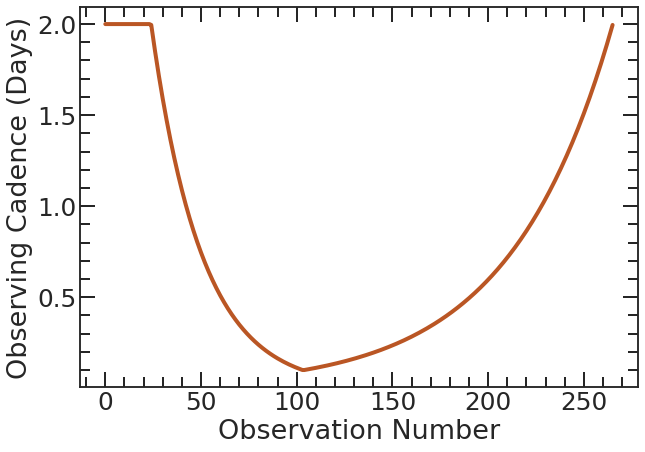

In [187]:
#increase the sampling for TDEs and Kilonovae
days_span=200
half = days_span/2
forward = np.logspace(-1, 0.3, 162)
backward = np.logspace(-1, 0.3, 80)
backward = np.flip(backward)
backward_pad = [2]*int((half-np.nansum(backward))/2)
backward_pad = np.array(backward_pad)
full_spacing = np.concatenate([backward_pad, backward, forward])

plt.figure(figsize=(10,7))
plt.xlabel("Observation Number")
plt.ylabel("Observing Cadence (Days)")
plt.plot(full_spacing, lw=4, c='#BA5624')
plt.savefig("../plots/VariableSampling_CadencePlot.png",dpi=200,bbox_inches='tight')

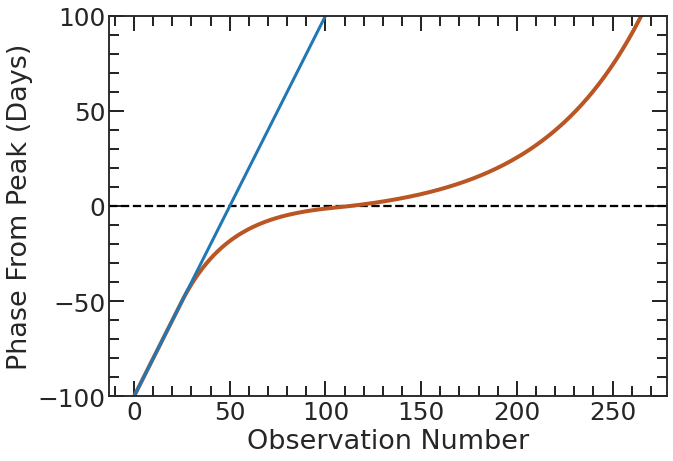

In [204]:
mjdsteps = np.zeros(len(full_spacing))
mjdsteps[0] = 53100
for i in np.arange(1,len(full_spacing)):
    mjdsteps[i] = mjdsteps[i-1] + full_spacing[i-1]
    
t_exp = 53200

plt.figure(figsize=(10,7))
plt.xlabel("Observation Number")
plt.axhline(0, color='k', ls='--')
plt.ylabel("Phase From Peak (Days)")
plt.plot(mjdsteps-t_exp, lw=4, c='#BA5624')
plt.ylim((-100, 100))
plt.plot(simlib_u['MJD'].values-t_exp, lw=3)
plt.savefig("../plots/VariableSampling_PhasePlot.png",dpi=200,bbox_inches='tight')

In [146]:
mjdsteps[-1]

53300.06620654653

In [205]:
######## Some diagnostics below ############

hdr = ["MJD", "IDEXPT", "FLT", "CCD GAIN", "CCD NOISE", "SKYSIG", "PSF1", "PSF2", "PSF 2/1 RATIO", "ZPTAVG", "ZPTERR", "MAG"]
simlib = pd.read_csv(rootPath + "/SCOTCH_IDEAL_0.1DAY.SIMLIB", skiprows=8, names=hdr, delim_whitespace=True, skipfooter=2)
simlib

/global/common/software/lsst/common/miniconda/dev-v1r1/envs/desc/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,MJD,IDEXPT,FLT,CCD GAIN,CCD NOISE,SKYSIG,PSF1,PSF2,PSF 2/1 RATIO,ZPTAVG,ZPTERR,MAG
S:,53100.0,10001,u,1.0,1.0,40.0,1.0,0.0,0.0,35.0,0.0,99
S:,53100.0,10002,g,1.0,1.0,40.0,1.0,0.0,0.0,35.0,0.0,99
S:,53100.0,10003,r,1.0,1.0,40.0,1.0,0.0,0.0,35.0,0.0,99
S:,53100.0,10004,i,1.0,1.0,40.0,1.0,0.0,0.0,35.0,0.0,99
S:,53100.0,10005,z,1.0,1.0,40.0,1.0,0.0,0.0,35.0,0.0,99
...,...,...,...,...,...,...,...,...,...,...,...,...
S:,53300.0,22001,u,1.0,1.0,40.0,1.0,0.0,0.0,35.0,0.0,99
S:,53300.0,22002,g,1.0,1.0,40.0,1.0,0.0,0.0,35.0,0.0,99
S:,53300.0,22003,r,1.0,1.0,40.0,1.0,0.0,0.0,35.0,0.0,99
S:,53300.0,22004,i,1.0,1.0,40.0,1.0,0.0,0.0,35.0,0.0,99
